In [72]:
import prescient
import numpy as np
import pandas as pd
import sklearn
import umap
import scipy
import annoy
import torch
import matplotlib.pyplot as plt

## Load data

Make sure to have downloaded the Veres 2019 et. al. data to this directory as described on the "Usage notebooks" tab.

In [20]:
expr = pd.read_csv("/Users/sachit/Dropbox (MIT)/prescient-data/data/Veres2019/Stage_5.Seurat.csv", index_col=0)
expr.head()

,SST,PYY,GCG,TTR,PPY,TAC1,GC,INS,NTS,CCK,...,LANCL3,FAM193A,FMN1,TPM1,VWA8,ERMAP,PTGS1,HEYL,C9orf43,ANKRD20A4
stg5diff1_S5d0_b1.bcEKBI,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.716086,0.0,...,0.0,0.420816,0.0,1.829704,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcDAND,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,1.866169,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcGQEK,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,1.007309,0.0,2.073536,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcFOEC,0.000000,0.0,0.0,1.175463,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,1.700974,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcAVAX,1.272205,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,1.272205,0.0,0.000000,1.272205,0.0,0.0,0.0,0.0,0.0


In [13]:
metadata = pd.read_csv("/Users/sachit/Dropbox (MIT)/prescient-data/data/Veres2019/GSE114412_Stage_5.all.cell_metadata.csv", index_col = 0)
metadata.head()

,Assigned_cluster,Assigned_subcluster,tSNE_dim1,tSNE_dim2,Differentiation,CellWeek,Lib_prep_batch,Indrops_barcode_sequence
library.barcode,,,,,,,,
stg5diff1_S5d0_b1.bcEKBI,prog_sox2,prog_sox2,-23.483145,-17.515814,1,0,stg5diff1_S5d0_b1,AGGCAACG-AAGCGTAC
stg5diff1_S5d0_b1.bcDAND,fev_high_isl_low,fev_high_isl_low__day0,6.776112,29.839868,1,0,stg5diff1_S5d0_b1,GAATGGAAAT-AGCGAAGT
stg5diff1_S5d0_b1.bcGQEK,prog_sox2,prog_sox2,-27.248994,-14.215368,1,0,stg5diff1_S5d0_b1,TGAGGTCTGAC-TCTCACTT
stg5diff1_S5d0_b1.bcFOEC,prog_sox2,prog_sox2,-30.845154,-7.473947,1,0,stg5diff1_S5d0_b1,ACTGAGTGC-AAGCGTAC
stg5diff1_S5d0_b1.bcAVAX,prog_sox2,prog_sox2,-7.391701,-16.014836,1,0,stg5diff1_S5d0_b1,AGATGTATT-ATGACTTT


## Scale normalized expression for PCA
For PCA dimensionality reduction, scaled features are necessary. Here we use sklearn's StandardScaler().

In [15]:
scaler = sklearn.preprocessing.StandardScaler()
xs = pd.DataFrame(scaler.fit_transform(expr), index = expr.index, columns = expr.columns)

## Computing growth using built-in PRESCIENT commands

In [70]:
pca = sklearn.decomposition.PCA(n_components = 30)
xp_ = pca.fit_transform(xs)

In [53]:
def compute_growth(L0, L, k, birth_score, death_score, birth_smoothed_score, death_smoothed_score):
    L = float(L)
    L0 = float(L0)
    k = float(k)

    kb = np.log(k) / np.min(birth_score)
    kd = np.log(k) / np.min(death_score)

    b = birth_smoothed_score
    d = death_smoothed_score

    b = L0 + L / (1 + np.exp(-kb * b))
    d = L0 + L / (1 + np.exp(-kd * d))
    g = b - d
    return g

In [66]:
def get_growth_weights(x, xp, metadata, tp_col, genes, birth_gst, death_gst, outfile, 
                       n_neighbors=20, beta=0.1, L0=0.3, L=1.1, k=0.001):
    """
    Estimate growth using KEGG gene annotations. Implements smoothing procedure.

    Inputs:
    -------
    x: numpy ndarray of scaled gene expression.
    xp: numpy ndarray of PCs.
    genes: list or numpy array of highly variable gene symbols.
    birth_gst: path to csv of birth signature annotations.
    death_gst: path to csv of death signature annotations.
    outfile: provide name of outfile pt.

    Outputs:
    --------
    weights: growth rates vector.
    """
    gst = pd.read_csv(birth_gst, index_col=0)
    birth_gst = [g for g in gst['gene_symbol'].unique() if g in genes]
    gst = pd.read_csv(death_gst, index_col = 0)
    death_gst = [g for g in gst['gene_symbol'].unique() if g in genes]

    birth_gst = [g for g in birth_gst if g not in death_gst]
    death_gst = [g for g in death_gst if g not in birth_gst]

    # smoothing procedure for growth
    ay = annoy.AnnoyIndex(xp.shape[1], 'euclidean')
    for i in range(xp.shape[0]):
        ay.add_item(i, xp[i])
    ay.build(10)
    
    prev_score = x[birth_gst].mean(axis = 1).values
    cur_score = np.zeros(prev_score.shape)

    for _ in range(5): 
        for i in range(len(prev_score)): 
            xn = prev_score[ay.get_nns_by_item(i, 20)]
            cur_score[i] = (beta * xn[0]) + ((1 - beta) * xn[1:].mean(axis = 0))
        prev_score = cur_score

    birth_score = x[birth_gst].mean(axis = 1).values
    birth_smoothed_score = cur_score

    # smooth death score

    prev_score = x[death_gst].mean(axis = 1).values
    cur_score = np.zeros(prev_score.shape)

    for _ in range(5): 
        for i in range(len(prev_score)): 
            xn = prev_score[ay.get_nns_by_item(i, 20)]
            cur_score[i] = (beta * xn[0]) + ((1 - beta) * xn[1:].mean(axis = 0))
        prev_score = cur_score

    death_score = x[death_gst].mean(axis = 1).values  
    death_smoothed_score = cur_score

    # compute growth
    g = compute_growth(L0, L, k, 
                       birth_score, death_score,
                       birth_smoothed_score, death_smoothed_score)
    y_l = sorted(metadata[tp_col].unique())
    g_l = [g[(metadata[tp_col] == y_).values] for y_ in y_l]
    
    # write growth
    torch.save({
        "w": g_l
    }, outfile)
    
    return g, g_l
    

In [78]:
g, g_l=get_growth_weights(xs, xp_, metadata, tp_col="CellWeek", genes=list(expr.columns), 
                   birth_gst="/Users/sachit/Dropbox (MIT)/prescient-data/data/Veres2019/hs_birth_msigdb_kegg.csv",
                   death_gst="/Users/sachit/Dropbox (MIT)/prescient-data/data/Veres2019/hs_death_msigdb_kegg.csv",
                   outfile="./growth-kegg.pt"
                  )

[ 0.91708278 -0.17322642  0.91243142 ... -0.73150036 -0.11345266
  0.94397065]


## Visualize growth weights
You can now visualize the computed growth/proliferation score per cell on a UMAP visualization of the data.

In [ ]:
um = umap.UMAP(n_components = 2, metric = 'euclidean', n_neighbors = 30)
xu = um.fit_transform(xp_)

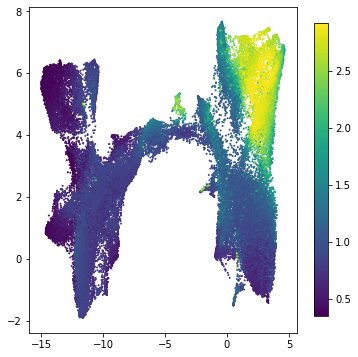

In [77]:
fig, ax = plt.subplots(figsize = (6,6))

c = np.exp(g)
ci = np.argsort(c)
sax = ax.scatter(-xu[ci,0], xu[ci,1], s = 1, c = c[ci])

plt.colorbar(sax, shrink = 0.9)

## Use weight torch file in process_data command

You can now use the growth weights file produced in the process_data command as follows:
```
prescient process_data -d data/Veres2019/Stage_5.Seurat.csv -m data/Veres2019/GSE114412_Stage_5.all.cell_metadata.csv --growth_path data/Veres2019/growth-kegg.pt -o './' --tp_col 'CellWeek' --celltype_col 'Assigned_cluster'
```
This command will produce a ```data.pt``` file that is used for the remainder of the training, simulation, and perturbation steps of PRESCIENT as outlined in Quickstart and Documentation.